In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import scipy.io as sio
from scipy.signal import welch

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Assuming you have these classes defined in a separate file, import them
from sleepdetector_new import ImprovedSleepdetector

class EnsembleModel(nn.Module):
    def __init__(self, model_params, n_models=3):
        super().__init__()
        self.models = nn.ModuleList([ImprovedSleepdetector(**model_params) for _ in range(n_models)])
    
    def forward(self, x, spectral_features):
        outputs = [model(x.clone(), spectral_features.clone()) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

def load_data(filepath, labels_file):
    try:
        mat_file = sio.loadmat(filepath)
        x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=0)
        x = torch.from_numpy(x).float()
        y_true = sio.loadmat(labels_file)['labels'].flatten() - 1
        y = torch.from_numpy(y_true).long()
        return x.permute(1, 0, 2, 3).squeeze(-1), y
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

def extract_spectral_features(x):
    features = []
    for channel in x:
        f, psd = welch(channel.squeeze().numpy(), fs=100, nperseg=1000)
        delta = np.sum(psd[(f >= 0.5) & (f <= 4)])
        theta = np.sum(psd[(f > 4) & (f <= 8)])
        alpha = np.sum(psd[(f > 8) & (f <= 13)])
        beta = np.sum(psd[(f > 13) & (f <= 30)])
        features.extend([delta, theta, alpha, beta])
    return np.array(features)

def prepare_test_data(x, y):
    X_test_spectral = np.array([extract_spectral_features(torch.from_numpy(x_i)) for x_i in x.numpy()])
    return torch.from_numpy(x.numpy()).float(), torch.from_numpy(X_test_spectral).float(), y

def evaluate_model(model, data, device):
    model.eval()
    X, X_spectral, y = data
    with torch.no_grad():
        outputs = model(X.to(device), X_spectral.to(device))
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
        kappa = cohen_kappa_score(y.cpu().numpy(), predicted.cpu().numpy())
    return accuracy, kappa, predicted.cpu().numpy()

def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix, without normalization'

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, square=True, 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)
    
    plt.tight_layout()
    return fig


2024-09-19 13:56:55,605 - INFO - Using device: cpu
2024-09-19 13:56:55,617 - INFO - Loaded best model parameters: {'n_filters': [64, 128, 256], 'lstm_hidden': 270, 'lstm_layers': 1, 'dropout': 0.1724846458910379}
/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_59939/3399949591.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights

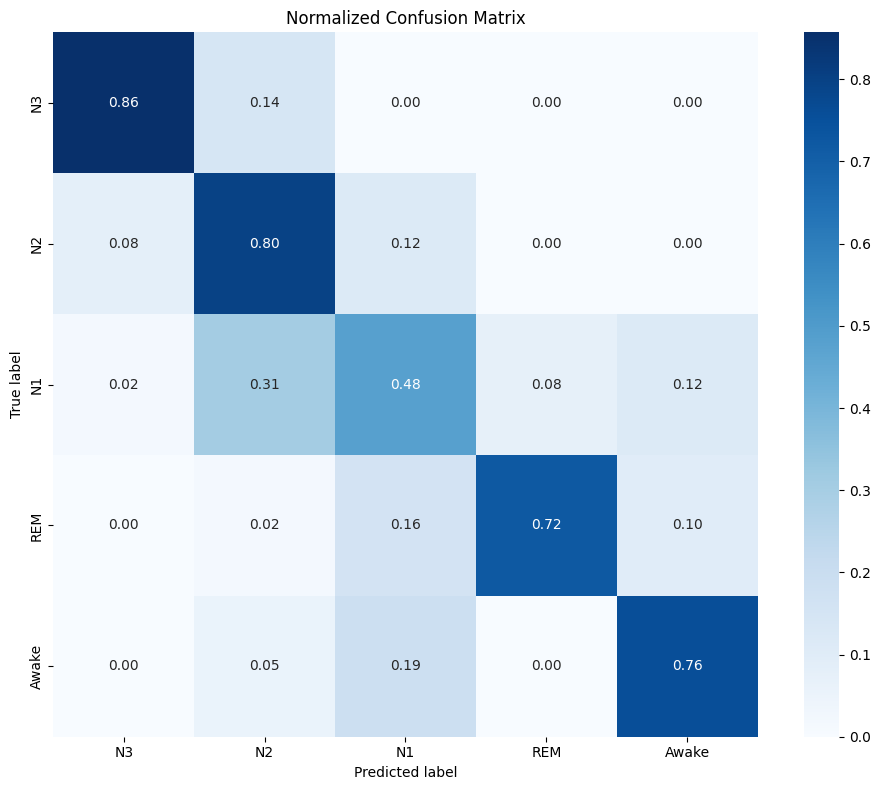

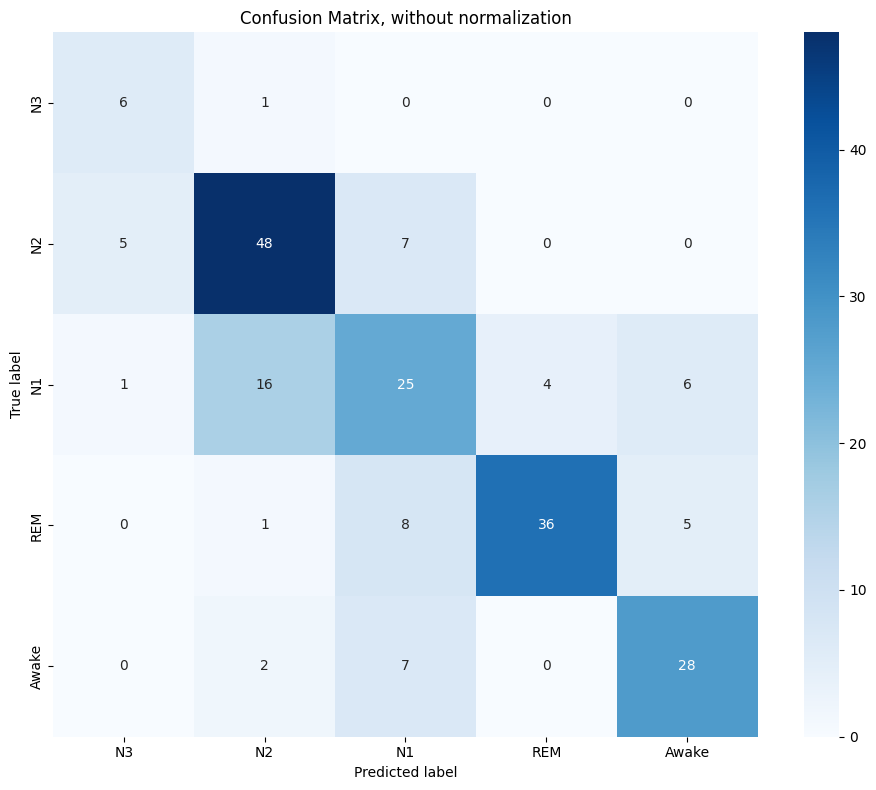

In [3]:
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")


try:
    # Load the best parameters from JSON file
    with open('./models/best_params_ensemble.json', 'r') as f:
        params = json.load(f)
    
    best_model_params = params['best_model_params']
    logging.info(f"Loaded best model parameters: {best_model_params}")

    # Load the saved model
    model_state = torch.load("./models/best_ensemble_model.pth", map_location=device)
    
    # Recreate the model architecture using the loaded parameters
    model = EnsembleModel(best_model_params, n_models=3).to(device)
    
    # Load the state dict
    model.load_state_dict(model_state)
    logging.info("Model loaded successfully")

    # # Load and prepare test data
    # x_test, y_test = load_data('../data/data.mat', '../data/labels.mat')
    # X_test, X_test_spectral, y_test = prepare_test_data(x_test, y_test)


    # Load the data from the JSON file
    with open('./models/test_data_emsemble.json', 'r') as f:
        loaded_data = json.load(f)

    # Convert lists back to tensors
    X_test = torch.tensor(loaded_data['X_test'])
    X_test_spectral = torch.tensor(loaded_data['X_test_spectral'])
    y_test = torch.tensor(loaded_data['y_test'])
    logging.info("Test data loaded and prepared successfully")

    # Evaluate the model
    accuracy, kappa, predictions = evaluate_model(model, (X_test, X_test_spectral, y_test), device)
    
    logging.info(f"Test Accuracy: {accuracy:.4f}")
    logging.info(f"Cohen's Kappa: {kappa:.4f}")

    # Plot and save confusion matrices
    fig_norm = plot_confusion_matrix(y_test.numpy(), predictions, normalize=True)
    fig_norm.savefig('./images/confusion_matrix_normalized.png')
    logging.info("Normalized confusion matrix saved to 'images' folder as 'confusion_matrix_normalized.png'") 
    

    fig_non_norm = plot_confusion_matrix(y_test.numpy(), predictions, normalize=False)
    fig_non_norm.savefig('./images/confusion_matrix_non_normalized.png')
    logging.info("Non-normalized confusion matrix saved to 'images' folder as 'confusion_matrix_non_normalized.png'")

except Exception as e:
    logging.error(f"An error occurred: {e}")